# 2D Linear Regression Module for NREL Spreadsheet

Assumption:
- `steam split` is a variable from 0 to 1, with 0 meaning all steam goes to LP steam turbine.
- All parameters are functions of both load factor and steam split

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# global matplotlib set

# matplotlib.rcParams['text.usetex'] = True

settings = {
    'font.family': 'Arial',
    'font.size': 20,
    'figure.autolayout' : True,
    'axes.facecolor': 'white',
    # 'figure.figsize': (10, 6),
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    # 'axes.titlesize': 10,
    'lines.linewidth': 3
}
plt.rcParams.update(settings)

In [3]:
# read Excel file
source_file_name = "NGCC Performance - with and without Carbon Capture 12 15 2021.xlsx"
dfs = pd.read_excel("../resources/" + source_file_name, sheet_name=None, index_col=0, engine='openpyxl')

# strip whitespace for index
for df in dfs.values():
    df.index = df.index.str.strip()

df_no_carbon_cap = dfs['No Carbon Capture']
df_max_power = dfs['Max Power']
df_max_DAC = dfs['Max DAC']

- Data from `Max Power` has `load factor = row 1 value`, `steam split = 0`
- Data from `Max DAC` has `load factor = row 1 value`, `steam split = 1`

In [4]:
X0 = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.4, 0.3, 0.25]
X1 = np.array([(x, 0) for x in X0])
X2 = np.array([(x, 1) for x in X0])
X = np.concatenate((X1, X2), axis=0)

In [5]:
def gen_linear_function(y):
    """
    Generate linear function based on the y value.
    """
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, y)
    m, b = linear_regressor.coef_, linear_regressor.intercept_
    r2 = linear_regressor.score(X, y)

    print(f"m1:\n{m[0]:.9f}")
    print(f"m2:\n{m[1]:.9f}")
    print(f"b:\n{b:.9f}")
    print(f"r2:\n{r2:.4f}")

    return lambda x, y: m[0] * x + m[1] * y + b, r2

In [6]:
def plot_regression(f, origin_z, z_name, unit, r2):
    """
    Plot the regression results.

    The plot is a 3D plot, with energy split as x-axis, load factor as y-axis,
    z_name as z-axis. The regression plane is plotted as well as the original 
    z points.
    """

    # helper arrays
    endpoints = np.array([0, 1])
    array_0 = np.array([0, 0])
    array_1 = np.array([1, 1])

    # calculate plots for the regressed plane
    X_plot = np.linspace(0, 1, 2)
    Y_plot = np.linspace(0, 1, 2)
    XX, YY = np.meshgrid(X_plot, Y_plot)
    Z = f(XX, YY)

    # create canvas
    _ = plt.figure(figsize=(8, 10))
    ax = plt.axes(projection='3d')

    # --------------------------------------------------------------------------

    # the following part is plotted with alpha=0 simply for placeholding
    # plot the regression results
    ax.plot3D(array_0, endpoints, f(array_0, endpoints), alpha=0)
    ax.plot3D(array_1, endpoints, f(array_1, endpoints), alpha=0)
    # plot the original data
    ax.plot3D(X1[:, 0], X1[:, 1], origin_z[:10], c='red', marker='o', ms=12, alpha=0)
    ax.plot3D(X2[:, 0], X2[:, 1], origin_z[10:], c='red', marker='o', ms=12, alpha=0)

    # --------------------------------------------------------------------------

    # extra surface at y = 1
    z_ticks = ax.get_zticks()
    X_sur, Y_sur = np.meshgrid(endpoints, array_1)
    Z_sur = np.array([[z_ticks[1], z_ticks[1]], [z_ticks[-2], z_ticks[-2]]])
    ax.plot_surface(X_sur, Y_sur, Z_sur, color='white', alpha=0.2, linewidth=0)

    # extra axis/gridlines at y = 1
    # get current z range
    z_min, z_max = ax.get_zlim()
    # plot horizontal grids
    for z_tick in z_ticks[1:-1]:
        ax.plot3D([0, 1], [1, 1], [z_tick, z_tick], c='#b0b0b0', linewidth=0.8)
    # plot vertical grids
    x_ticks = [x for x in ax.get_xticks() if x >= 0 and x <= 1]
    for x_tick in x_ticks:
        ax.plot3D([x_tick, x_tick], [1, 1], [z_ticks[1], z_ticks[-2]], c='#b0b0b0', linewidth=0.8)

    # --------------------------------------------------------------------------

    # plot the regression results
    # ax.plot_wireframe(XX, YY, Z, rcount=1, ccount=1, color='black', zorder=1)
    ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, color='cyan', edgecolor='none', alpha=0.075)
    ax.plot3D(array_0, endpoints, f(array_0, endpoints), c='cyan', alpha=0.2)
    ax.plot3D(array_1, endpoints, f(array_1, endpoints), c='cyan', alpha=0.2)
    ax.plot3D(endpoints, array_0, f(endpoints, array_0), c='cyan', marker='o', ms=12, label="linear regression (extended to 0)")
    ax.plot3D(endpoints, array_1, f(endpoints, array_1), c='cyan', marker='o', ms=12)

    # plot the original data
    ax.plot3D(X1[:, 0], X1[:, 1], origin_z[:10], c='red', marker='o', ms=12, label="simulation results")
    ax.plot3D(X2[:, 0], X2[:, 1], origin_z[10:], c='red', marker='o', ms=12)

    # add text for r2
    ax.text2D(-0.09, 0.075, rf"$r^2$ = {r2:.4f}")


    # --------------------------------------------------------------------------

    # reset z range
    ax.set_zlim([z_min, z_max])
    # add labels and title
    ax.set_xlabel('load factor', labelpad=20)
    ax.set_ylabel('energy split', labelpad=20)
    ax.set_title(z_name + ', ' + unit)

    # plot legend
    ax.legend(loc=1)

    # set x and y limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # set y ticks
    ax.set_yticks([0, 1])

    # invert y-axis
    ax.invert_yaxis()

    # adjust view angle
    ax.view_init(20, 40)

    # save figure
    plt.savefig(f"regression_{z_name.replace(' ', '_')}.png", format="png", 
                bbox_inches="tight"
                )

## net heat rate at plant-level of NGCC with CCS

- data row: `HHV Net Plant Heat Rate`
- unit: MMBTU/MWh (HHV basis)

m1:
-2.727620574
m2:
2.484102702
b:
10.357831182
r2:
0.8293


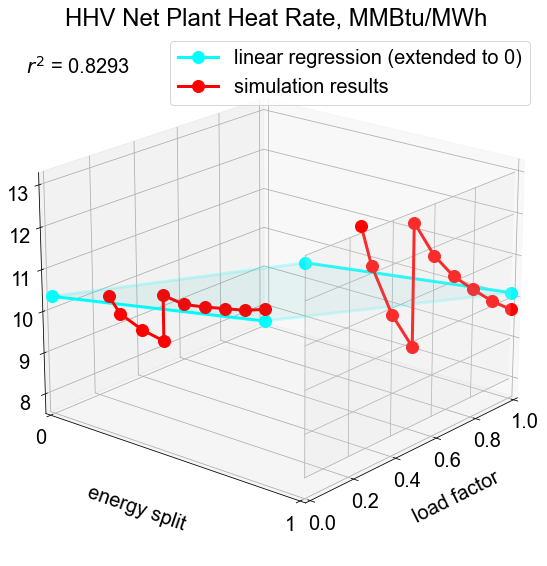

In [244]:
row_name = 'HHV Net Plant Heat Rate'
unit = 'MMBtu/MWh'
# unit conversion: BTU/kWh to MMBtu/MWh
y1 = df_max_power.loc[row_name, 1:] / 1000
y2 = df_max_DAC.loc[row_name, 1:] / 1000
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

## CO2 emission rate

- data row: `CO2 Emission Rate`
- unit: t CO2/MWh

m1:
0.100689746
m2:
-0.307779434
b:
-0.114240216
r2:
0.9437


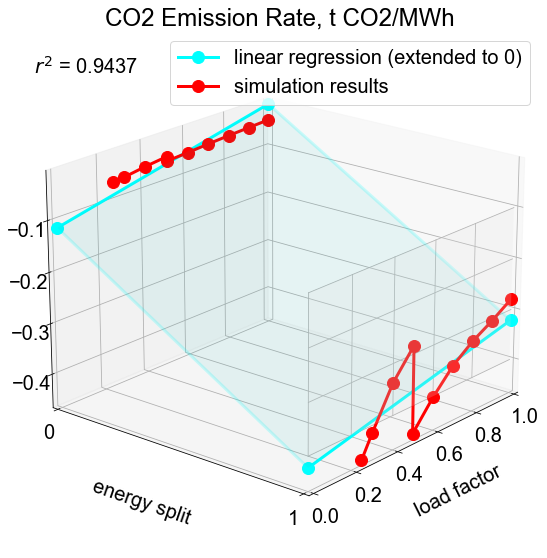

In [330]:
row_name = 'CO2 Emission Rate'
unit = 't CO2/MWh'

y1 = df_max_power.loc[row_name, 1:].iloc[1, :]
y2 = df_max_DAC.loc[row_name, 1:].iloc[1, :]
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

## Auxiliary load minus PCC/DAC

- data row: `A15:A24, A34`
- unit: MWh/MWh

m1:
-0.032997796
m2:
0.009968721
b:
0.058015881
r2:
0.8219


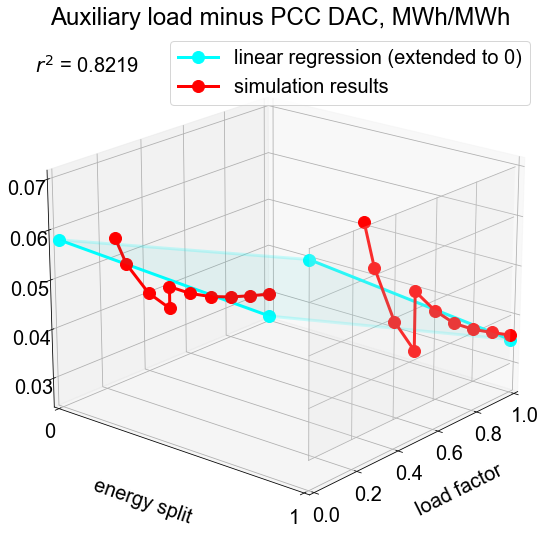

In [7]:
row_name = 'Auxiliary load minus PCC DAC'
unit = 'MWh/MWh'

aux_rows = ["Circulating Water Pumps",
            "Combustion Turbine Auxiliaries",
            "Condensate Pumps",
            "Cooling Tower Fans",
            "Feedwater Pumps",
            "Ground Water Pumps",
            "Miscellaneous Balance of Plant",
            "SCR",
            "Steam Turbine Auxiliaries",
            "Transformer Losses"
            ]
y1_1 = df_max_power.loc[aux_rows].sum()[1:]
y1_2 = df_max_power.loc["Net Power", :].iloc[0, 1:]
y1 = y1_1 / y1_2
y2_1 = df_max_DAC.loc[aux_rows].sum()[1:]
y2_2 = df_max_DAC.loc["Net Power", :].iloc[0, 1:]
y2 = y2_1 / y2_2
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

In [9]:
y2

1        0.035893
0.9      0.038251
0.8      0.040674
0.7      0.043685
0.6       0.04799
0.5      0.053512
0.5.1    0.041862
0.4      0.049333
0.3      0.061475
0.25     0.070835
dtype: object

## max CCS equivalent parasitic load (energy penalty)

- data row: `max CCS equivalent parasitic load (energy penalty) under each operational mode, as a percent of base NGCC power output without CCS`
- unit: %

m1:
-0.070559238
m2:
0.172335876
b:
0.251143889
r2:
0.9387


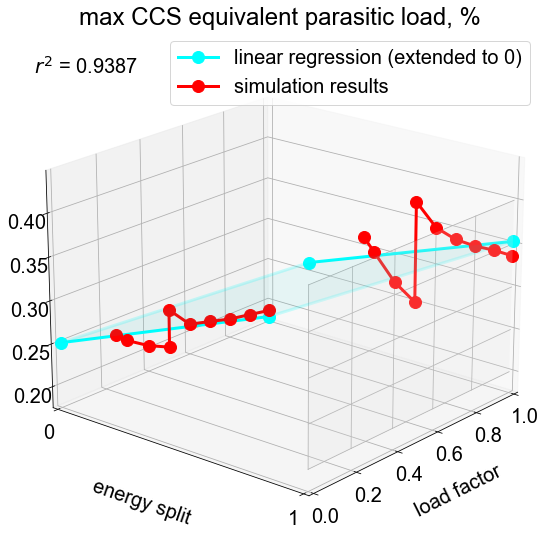

In [272]:
row_name = 'max CCS equivalent parasitic load'
unit = '%'

y1 = df_max_power.iloc[111, 1:]
y2 = df_max_DAC.iloc[111, 1:]
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

## water withdrawal rate

- data row: `Total Raw Water Demand`, `Net Power`
- unit: m^3/kWh

m1:
-0.001121165
m2:
0.000978529
b:
0.003046769
r2:
0.8338


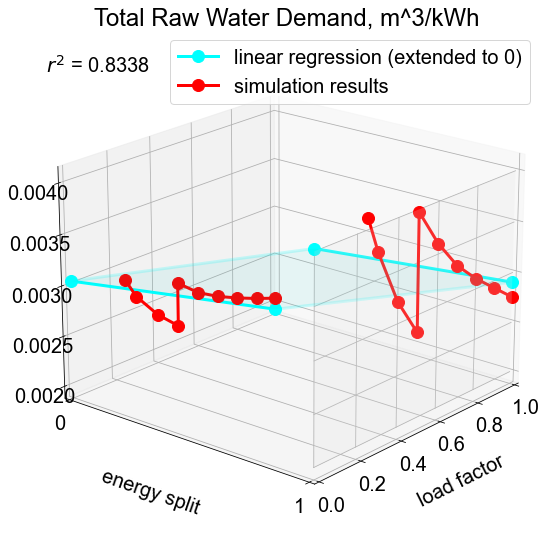

In [10]:
row_name = 'Total Raw Water Demand'
unit = 'm^3/kWh'

gpm_to_m3h = 0.227125

y1_1 = df_max_power.loc[row_name, 1:]  # gpm
y1_2 = df_max_power.loc["Net Power", :].iloc[0, 1:]  # kW
y1 = y1_1 / y1_2 * gpm_to_m3h
y2_1 = df_max_DAC.loc[row_name, 1:]
y2_2 = df_max_DAC.loc["Net Power", :].iloc[0, 1:]
y2 = y2_1 / y2_2 * gpm_to_m3h
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

In [12]:
y2

1        0.002757
0.9       0.00293
0.8      0.003103
0.7       0.00331
0.6      0.003599
0.5      0.003975
0.5.1    0.002831
0.4      0.003207
0.3      0.003758
0.25     0.004113
dtype: object

## water consumption rate

- data row: `Total Raw Water Consumption`, `Net Power`
- unit: m^3/kWh

m1:
-0.000728864
m2:
0.000359009
b:
0.002179826
r2:
0.7415


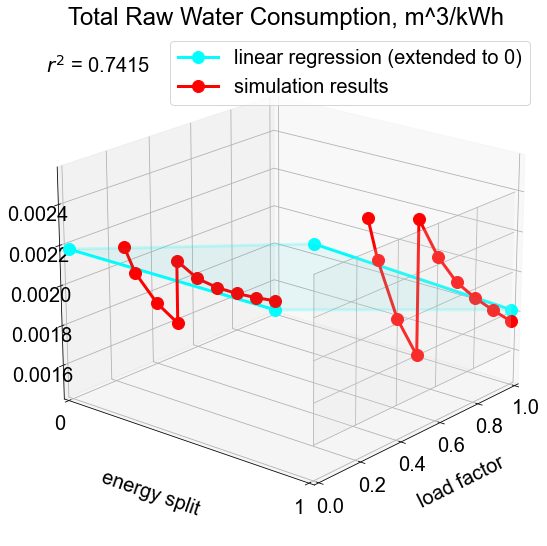

In [13]:
row_name = 'Total Raw Water Consumption'
unit = 'm^3/kWh'

gpm_to_m3h = 0.227125

y1_1 = df_max_power.loc[row_name, 1:]  # gpm
y1_2 = df_max_power.loc["Net Power", :].iloc[0, 1:]  # kW
y1 = y1_1 / y1_2 * gpm_to_m3h
y2_1 = df_max_DAC.loc[row_name, 1:]
y2_2 = df_max_DAC.loc["Net Power", :].iloc[0, 1:]
y2 = y2_1 / y2_2 * gpm_to_m3h
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

In [17]:
y2

1        0.001751
0.9       0.00185
0.8      0.001954
0.7      0.002074
0.6      0.002239
0.5      0.002459
0.5.1    0.001801
0.4      0.002021
0.3      0.002343
0.25     0.002559
dtype: object

## Net power

- data row: `Net Power`
- unit: kW

m1:
538.746291924
m2:
-74.769550628
b:
30.417240673
r2:
0.9896


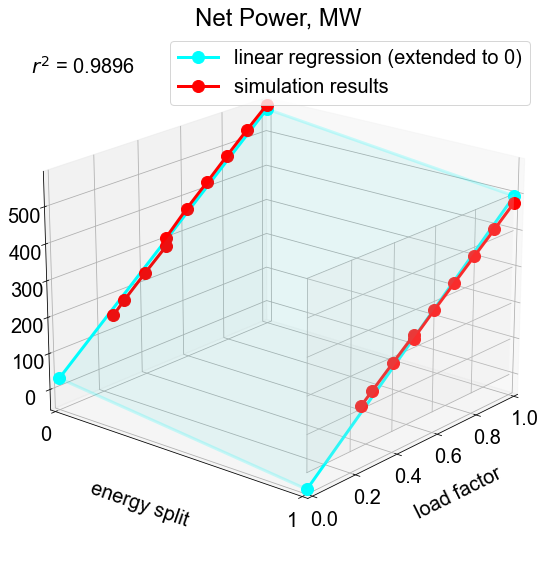

In [18]:
row_name = 'Net Power'
unit = 'MW'

y1 = df_max_power.loc["Net Power", :].iloc[0, 1:] / 1000 # MW
y2 = df_max_DAC.loc["Net Power", :].iloc[0, 1:] / 1000 # MW
y = list(y1) + list(y2)

f, r2 = gen_linear_function(y)
plot_regression(f, y, row_name, unit, r2)

## net heat rate at plant-level of base NGCC without CCS

- data row: `HHV Net Plant Heat Rate`
- unit: MMBTU/MWh (HHV basis)

In [275]:
def gen_linear_function_1D(y):
    """
    Generate linear function based on the y value.
    """
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, y)
    m, b = linear_regressor.coef_, linear_regressor.intercept_
    r2 = linear_regressor.score(X, y)

    print(f"m:\n{m[0]:.9f}")
    print(f"b:\n{b:.9f}")
    print(f"r2:\n{r2:.4f}")

    return lambda x: m[0] * x + b, r2

In [287]:
X = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.5, 0.4, 0.3, 0.25]).reshape(-1, 1)

In [325]:
def plot_regression_1D(f, origin_z, z_name, unit, r2, text_loc=7.5):
    """
    Plot the regression results.

    The plot is a 3D plot, with energy split as x-axis, load factor as y-axis,
    z_name as z-axis. The regression plane is plotted as well as the original 
    z points.
    """

    # helper arrays
    endpoints = np.array([0, 1])

    # create canvas
    _ = plt.figure(figsize=(6, 6))
    ax = plt.axes()

    # --------------------------------------------------------------------------

    # the following part is plotted with alpha=0 simply for placeholding
    # plot the regression results
    ax.plot(endpoints, f(endpoints), c='cyan', marker='o', ms=12, label="linear regression (extended to 0)")

    # plot the original data
    ax.plot(X, origin_z, c='red', marker='o', ms=12, label="simulation results")

    # add text for r2
    ax.text(0.65, text_loc, rf"$r^2$ = {r2:.4f}")

    # --------------------------------------------------------------------------

    # add labels and title
    ax.set_xlabel('load factor', labelpad=20)
    ax.set_title(z_name + ', ' + unit)

    # plot legend
    ax.legend(loc=(1.05, 0.8))

    # set x and y limits
    ax.set_xlim([0, 1])

    # save figure
    plt.savefig(f"regression_1D_{z_name.replace(' ', '_')}.png", format="png", 
                bbox_inches="tight"
                )

m1:
-1.114716928
b:
7.561790741
r2:
0.6971


<ipython-input-320-9998d0f5092a>:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(f"regression_1D_{z_name.replace(' ', '_')}.png", format="png",
/Users/pengfeicheng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


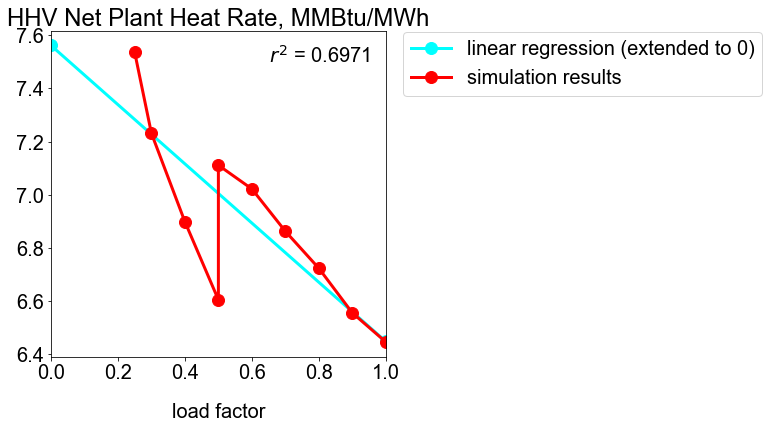

In [321]:
row_name = 'HHV Net Plant Heat Rate'
unit = 'MMBtu/MWh'
# unit conversion: BTU/kWh to MMBtu/MWh
y = df_no_carbon_cap.loc[row_name, 1:0.25] / 1000

f, r2 = gen_linear_function_1D(y)
plot_regression_1D(f, y, row_name, unit, r2)

## CO2 emission rate of base NGCC without CCS

- data row: `CO2 Emission Rate`
- unit: t CO2/MWh

m1:
-0.062829052
b:
0.423531159
r2:
0.6949


<ipython-input-325-80131e306d96>:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(f"regression_1D_{z_name.replace(' ', '_')}.png", format="png",
/Users/pengfeicheng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


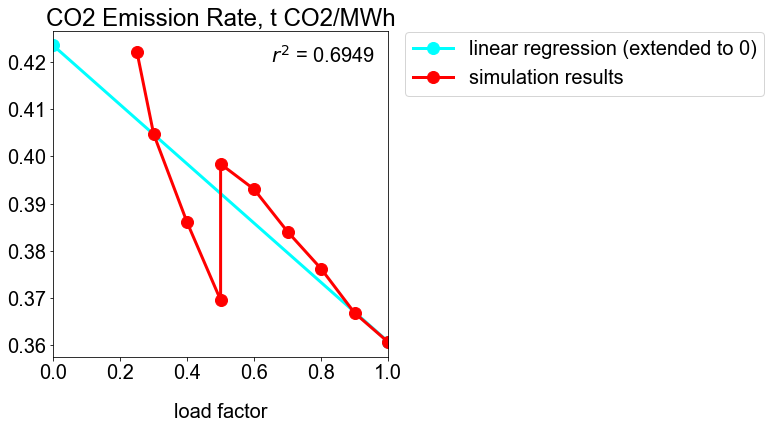

In [327]:
row_name = 'CO2 Emission Rate'
unit = 't CO2/MWh'

y = df_no_carbon_cap.loc[row_name, 1:0.25]

f, r2 = gen_linear_function_1D(y)
plot_regression_1D(f, y, row_name, unit, r2, text_loc=0.42)